In [117]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
import bisect
import functools
from multiprocessing import Pool
import itertools
import pickle as pkl
%matplotlib inline

In [2]:
# read all band images in a directory
images = {}
image_dir = 'earthengine_images/'
for fn in os.listdir(image_dir):
    raw = gdal.Open(image_dir + fn)
    arr = raw.ReadAsArray()
    images[fn.split('.')[0]] = arr

In [3]:
for k, v in images.items():
    print(k + ' ' + str(v.shape))

LC80930862015280 (3, 655, 894)
LC80930862015056 (3, 655, 894)
LC80930862015264 (3, 655, 894)
LC80930862016091 (3, 655, 894)
LC80940862016082 (3, 655, 894)
LC80930862015168 (3, 655, 894)
LC80940862015111 (3, 655, 894)
LC80930862016043 (3, 655, 894)
LC80940862016002 (3, 655, 894)
LC80930862015120 (3, 655, 894)
LC80930862015152 (3, 655, 894)
LC80930862015072 (3, 655, 894)
LC80940862015207 (3, 655, 894)
LC80940862015175 (3, 655, 894)
LC80930862016011 (3, 655, 894)
LC80930862015040 (3, 655, 894)
LC80930862015216 (3, 655, 894)
LC80930862015200 (3, 655, 894)
LC80940862015255 (3, 655, 894)
LC80930862015232 (3, 655, 894)
LC80940862015047 (3, 655, 894)
LC80940862015095 (3, 655, 894)
LC80930862015248 (3, 655, 894)
LC80930862015360 (3, 655, 894)
LC80930862015184 (3, 655, 894)
LC80940862015239 (3, 655, 894)
LC80940862015143 (3, 655, 894)
LC80940862015159 (3, 655, 894)
LC80940862016018 (3, 655, 894)
LC80940862015223 (3, 655, 894)
LC80940862015287 (3, 655, 894)
LC80940862016034 (3, 655, 894)
LC809308

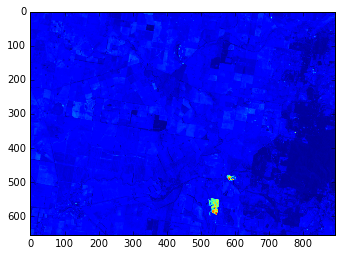

In [4]:
plt.imshow(images['LC80930862015040'][2, :, :])
plt.show()

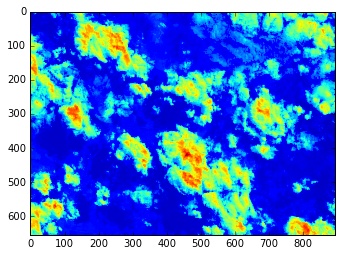

In [5]:
plt.imshow(images['LC80940862015079'][2, :, :])
plt.show()

In [6]:
# read all mask images in a directory
masks = {}
mask_dir = 'earthengine_masks/'
for fn in os.listdir(mask_dir):
    raw = gdal.Open(mask_dir + fn)
    arr = raw.ReadAsArray()
    masks[fn.split('.')[0]] = arr

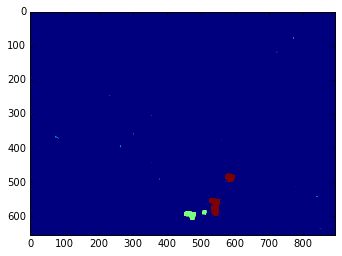

In [7]:
plt.imshow(masks['LC80930862015040'][0, :, :])
plt.show()

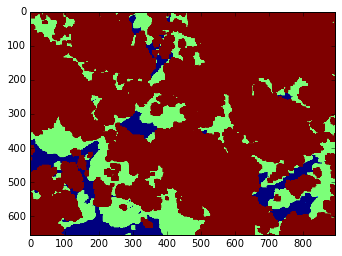

In [8]:
plt.imshow(masks['LC80940862015079'][0, :, :])
plt.show()

In [9]:
# compose band and mask images into one image
combined = {}
image_dir = 'earthengine_images/'
mask_dir = 'earthengine_masks/'
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)

In [10]:
print(combined['LC80940862015079'].shape)

(5, 655, 894)


In [11]:
# use image names to look up metadata from csv export
table = pd.read_csv('earthengine_tables/LC8_SR.csv')
time_start = table[['system:index', 'system:time_start']]

In [12]:
time_start

,system:index,system:time_start
0,LC80930862015040,1423440571231
1,LC80930862015056,1424822966175
2,LC80930862015072,1426205354132
3,LC80930862015088,1427587746370
4,LC80930862015120,1430352533188
5,LC80930862015136,1431734919028
6,LC80930862015152,1433117325195
7,LC80930862015168,1434499736147
8,LC80930862015184,1435882143244
9,LC80930862015200,1437264552573


In [13]:
time_start[time_start['system:index'] == 'LC80930862015040'].ix[0, 1]

1423440571231

In [14]:
# compose all data into a single data frame
ds = {}
for k, v in combined.items():
    ts = time_start[time_start['system:index'] == k]['system:time_start'].iloc[0]
    ds[ts] = v

In [15]:
print(ds.keys())

dict_keys([1440634536577, 1442016943362, 1459382957827, 1445558982533, 1458000568200, 1433117325195, 1435882143244, 1440029363213, 1428192911630, 1457223342061, 1426205354132, 1453853382683, 1424822966175, 1442794176672, 1449706184998, 1448323787335, 1452470982577, 1454458551604, 1450311357239, 1423440571231, 1436487319228, 1441411768125, 1424045737534, 1439252129269, 1427587746370, 1451088586307, 1430352533188, 1448928958023, 1438646955592, 1426810523472, 1434499736147, 1447546555861, 1444781749463, 1458605735131, 1429575310943, 1446164155488, 1451693755106, 1430957695975, 1446941385063, 1444176579436, 1433722502125, 1437869725294, 1455235776496, 1456618171987, 1431734919028, 1435104908414, 1432340092546, 1443399349500, 1437264552573, 1453076154238])


In [16]:
# getting ready for interpolation / training

In [17]:
# get time series at a point
def getTS(data, x, y):
    times = list(data.keys())
    times.sort()
    ts = dict(map(lambda t: (t, data[t][:, x, y]), times))
    df = pd.DataFrame(ts).transpose()
#     df['date'] = df.index.map(lambda t: str(datetime.datetime.fromtimestamp(t/1000).date()))
    return df

In [18]:
df = getTS(ds, 20, 30)
df

,0,1,2,3,4
1423440571231,2239,1308,902,0,1
1424045737534,4725,3901,3610,4,3
1424822966175,6510,6065,5937,4,3
1426205354132,2509,1226,873,0,1
1426810523472,876,326,223,2,1
1427587746370,2049,1016,727,0,1
1428192911630,7169,7103,7103,4,3
1429575310943,1768,749,535,4,3
1430352533188,2139,672,576,0,1
1430957695975,2041,632,478,4,2


cfmask: cloud mask.

    0=clear
    1=water
    2=shadow
    3=snow
    4=cloud

cfmask_conf: cloud mask confidence

    0=none
    1=cloud confidence ≤ 12.5%
    2=cloud confidence > 12.5% and ≤ 22.5%
    3=cloud confidence > 22.5%

In [19]:
def selectClear(df, level=1):
    return df.ix[(df.ix[:, 3] == 0) & (df.ix[:, 4] <= level), [0, 1, 2]]

In [20]:
clear = selectClear(df, 1)
clear

,0,1,2
1423440571231,2239,1308,902
1426205354132,2509,1226,873
1427587746370,2049,1016,727
1430352533188,2139,672,576
1431734919028,2275,453,465
1432340092546,3504,918,871
1435104908414,3376,387,566
1437264552573,3166,326,486
1438646955592,3513,266,454
1440029363213,4912,311,602


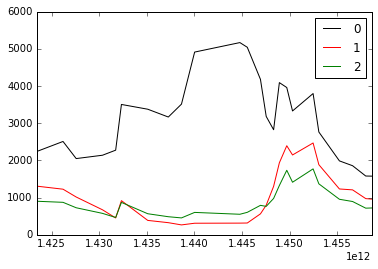

In [21]:
clear.plot(color=['k', 'r', 'g'])

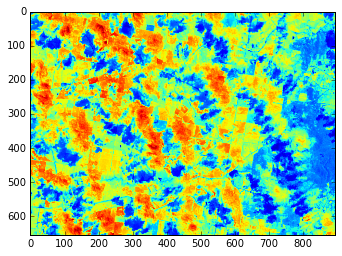

In [22]:
plt.imshow(ds[1444176579436][0, :, :])
plt.show()

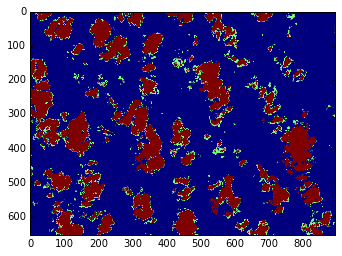

In [23]:
plt.imshow(ds[1444176579436][4, :, :])
plt.show()

In [24]:
str(datetime.datetime.fromtimestamp(1444176579436/1000).date())

'2015-10-07'

In [105]:
# interpolate at timestamp
def interpolate(data, timestamp):
    times = data.index
    if len(times) <= 0:
        return 0
    if timestamp <= times[0]:
        values = data.iloc[0, :3]
    elif timestamp >= times[-1]:
        values = data.iloc[-1, :3]
    else:
        i = bisect.bisect(times, timestamp)
        delta_x = timestamp - times[i - 1]
        if delta_x == 0:
            values = data.iloc[i - 1, :3]
        else:
            low = data.iloc[i - 1, :3]
            high = data.iloc[i, :3]
            interval = (times[i] - times[i - 1])
            values = low + (high - low) / interval * delta_x
    return values

In [106]:
# 1427587746370
mid = int((1433117325195 + 1437264552573) / 2)
two = int((1450311357239 + 1452470982577) / 2)
print(mid)
interpolate(clear, mid)

1435190938884


0    3367.634548
1     384.570035
2     562.813161
dtype: float64

In [27]:
# interpolate all points in an image

In [109]:
def interpolate_image(data, timestamps):
    dims = data[list(data.keys())[0]].shape
    dim_x = dims[1]
    dim_y = dims[2]
    pool = Pool(8)
    images = {t: np.zeros((3, dim_x, dim_y)) for t in timestamps}
    total_tasks = dim_x * dim_y * len(timestamps)
    progress = 0
    for x in range(0, dim_x):
        for y in range(0, dim_y):
#     for x in range(0, 100):
#         for y in range(0, 100):
            data_point = getTS(data, x, y)
            clear_point = selectClear(data_point, 1)
            for timestamp in timestamps:
                values = interpolate(clear_point, timestamp)
                images[timestamp][:, x, y] = values
                progress += 1
                if (progress % 1000 == 0):
                    print("progress:"  + str(progress / total_tasks * 100) + "%")
    return images

In [110]:
images = interpolate_image(ds, [mid, two])

progress:0.08538688798948033%
progress:0.17077377597896065%
progress:0.256160663968441%
progress:0.3415475519579213%
progress:0.42693443994740166%
progress:0.512321327936882%
progress:0.5977082159263624%
progress:0.6830951039158426%
progress:0.768481991905323%
progress:0.8538688798948033%
progress:0.9392557678842837%
progress:1.024642655873764%
progress:1.1100295438632444%
progress:1.1954164318527247%
progress:1.2808033198422049%
progress:1.3661902078316852%
progress:1.4515770958211656%
progress:1.536963983810646%
progress:1.6223508718001263%
progress:1.7077377597896066%
progress:1.793124647779087%
progress:1.8785115357685673%
progress:1.9638984237580477%
progress:2.049285311747528%
progress:2.1346721997370084%
progress:2.2200590877264887%
progress:2.305445975715969%
progress:2.3908328637054495%
progress:2.4762197516949294%
progress:2.5616066396844097%
progress:2.64699352767389%
progress:2.7323804156633704%
progress:2.8177673036528508%
progress:2.903154191642331%
progress:2.98854107963

In [118]:
pkl.dump(images, open('images.pickle', 'wb'))

In [119]:
saved = pkl.load(open('images.pickle', 'rb'))

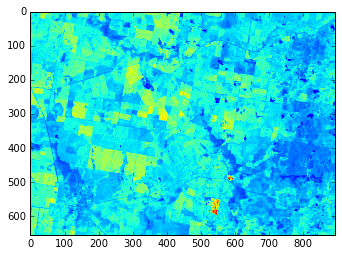

In [120]:
plt.imshow(saved[two][0, :, :])
plt.show()

In [106]:
# remove cloud and interpolate

In [113]:
def convert_to_dataframe(image):
    frame = pd.Panel(image).to_frame()
    return frame

In [114]:
convert_to_dataframe(images[mid])

0            1            2
major minor                                       
0     0      2974.016452   625.478026   651.163455
      1      2975.370858   609.637368   621.960165
      2      3033.940894   628.840658   645.964277
      3      3038.123619   628.362632   646.402468
      4      3146.243126   618.521974   650.282961
      5      3206.888719   604.844771   648.725265
      6      3192.844771   562.004113   623.322797
      7      3232.211516   551.442303   618.521974
      8      3281.936781   554.765100   654.530200
      9      3301.410694   536.167568   629.729377
      10     3345.335135   527.813161   623.092010
      11     3239.821387   475.446416   565.486252
      12     3187.012339   479.287074   579.888719
      13     3184.303526   478.968390   579.131845
      14     3096.295300   475.247239   560.287074
      15     3034.800823   465.526087   558.565923
      16     3101.052174   458.804935   560.486252
      17     3049.832432   403.792597   523.756874
      18     3043.100235   403.912103   523.637368
      19     2678.857110   370.796710   497.282961
      20     2489.777439   389.282961   502.565923
      21     2917.579555   482.215629   605.701881
      22     3218.223855   490.490365   639.374971
      23     3224.637368   490.331023   640.331023
      24     3412.814455   433.326910   620.016452
      25     3637.925735   406.601645   596.012339
      26     3647.527381   414.282961   589.291187
      27     3646.929848   414.920329   589.171681
      28     3474.200471   469.964277   580.450529
      29     3312.925735   526.083784   583.207403
...                  ...          ...          ...
654   864    4470.292248   533.594713   733.881787
      865    4470.292248   533.594713   733.881787
      866    4633.751003   498.307639   713.554877
      867    4814.811403   498.745829   741.554877
      868    4941.604000   515.032903   761.319977
      869    5191.246774   513.112574   779.563103
      870    5185.351123   512.953232   779.363926
      871    5344.407410   527.997181   806.009519
      872    5373.439019   583.284255   828.850177
      873    5508.320807   664.977910   872.499884
      874    5508.320807   664.977910   872.499884
      875    5586.655942   645.177087   888.986135
      876    5471.249361   569.523268   836.455935
      877    5406.815284   537.957345   802.531494
      878    5400.767223   608.531494   832.296594
      879    5400.767223   608.531494   832.296594
      880    5071.356529   869.631729   954.388603
      881    4785.275565  1050.153703  1041.432552
      882    4879.099771   956.994361   977.348768
      883    4990.091545   891.547945   966.304819
      884    4990.091545   891.547945   966.304819
      885    5214.816810   838.384490   943.982023
      886    5142.147832   830.587781   931.902352
      887    5364.892368   887.703174   983.982023
      888    5836.737139   871.583668  1016.384490
      889    5836.737139   871.583668  1016.384490
      890    5898.537961   936.587781  1061.667452
      891    5667.764636   976.711400  1093.830906
      892    5338.955587   948.747123  1031.264984
      893    4959.690603   897.858403   950.611165

[585570 rows x 3 columns]

In [115]:
def make_set(images):
    times = list(images.keys())
    res = pd.concat([convert_to_dataframe(i) for i in images.values()], axis=1, keys=images.keys())
#     res = pd.concat(list(map(convert_to_dataframe, images.values())), axis=0)
    return res.reset_index()

In [116]:
dataset = make_set(images)
dataset

major minor 1451391169908                           1435190938884  \
                               0            1            2             0   
0          0     0   3080.000000  1849.500000  1386.000000   2974.016452   
1          0     1   3056.500000  1782.000000  1317.500000   2975.370858   
2          0     2   3061.000000  1777.000000  1313.000000   3033.940894   
3          0     3   3054.000000  1771.000000  1306.000000   3038.123619   
4          0     4   3034.000000  1760.500000  1298.000000   3146.243126   
5          0     5   3045.000000  1760.000000  1295.000000   3206.888719   
6          0     6   2993.500000  1743.500000  1280.000000   3192.844771   
7          0     7   3027.500000  1766.500000  1299.500000   3232.211516   
8          0     8   3023.000000  1780.000000  1300.500000   3281.936781   
9          0     9   2996.500000  1755.500000  1276.500000   3301.410694   
10         0    10   3003.000000  1750.500000  1275.500000   3345.335135   
11         0    11   2971.500000  1732.500000  1270.500000   3239.821387   
12         0    12   2982.500000  1741.500000  1266.000000   3187.012339   
13         0    13   2972.500000  1739.000000  1264.000000   3184.303526   
14         0    14   2997.000000  1748.000000  1267.000000   3096.295300   
15         0    15   2972.500000  1730.500000  1260.500000   3034.800823   
16         0    16   2952.500000  1713.500000  1248.500000   3101.052174   
17         0    17   2887.500000  1646.500000  1199.000000   3049.832432   
18         0    18   2843.500000  1613.000000  1171.500000   3043.100235   
19         0    19   2622.000000  1522.500000  1072.500000   2678.857110   
20         0    20   2483.500000  1440.000000  1015.500000   2489.777439   
21         0    21   2534.000000  1467.500000  1039.500000   2917.579555   
22         0    22   2637.500000  1526.000000  1086.500000   3218.223855   
23         0    23   2683.000000  1552.500000  1109.000000   3224.637368   
24         0    24   2796.000000  1601.000000  1162.000000   3412.814455   
25         0    25   2948.500000  1661.500000  1204.500000   3637.925735   
26         0    26   2955.000000  1668.500000  1204.000000   3647.527381   
27         0    27   2937.500000  1661.500000  1194.000000   3646.929848   
28         0    28   2939.000000  1647.500000  1192.500000   3474.200471   
29         0    29   3040.500000  1692.500000  1237.000000   3312.925735   
...      ...   ...           ...          ...          ...           ...   
585540   654   864   3057.278815  1695.261740  1223.596551   4470.292248   
585541   654   865   3057.278815  1695.261740  1223.596551   4470.292248   
585542   654   866   3161.145811  1767.532184  1261.278982   4633.751003   
585543   654   867   3076.939901  1715.115929  1238.021512   4814.811403   
585544   654   868   3163.789654  1768.931363  1262.553695   4941.604000   
585545   654   869   3163.789654  1768.931363  1262.553695   5191.246774   
585546   654   870   3047.798192  1687.377668  1181.939901   5185.351123   
585547   654   871   2893.532017  1538.364694  1073.858291   5344.407410   
585548   654   872   2902.823806  1550.055663  1081.300327   5373.439019   
585549   654   873   2864.944003  1537.866829  1071.424793   5508.320807   
585550   654   874   2864.944003  1537.866829  1071.424793   5508.320807   
585551   654   875   2888.437600  1531.489161  1065.266008   5586.655942   
585552   654   876   2869.403282  1538.733825  1066.858291   5471.249361   
585553   654   877   2798.776681  1501.386206  1042.978488   5406.815284   
585554   654   878   2913.673726  1545.605089  1087.914121   5400.767223   
585555   654   879   2913.673726  1545.605089  1087.914121   5400.767223   
585556   654   880   2794.987026  1587.952708  1165.605089   5071.356529   
585557   654   881   2887.119864  1536.875367  1106.304596   4785.275565   
585558   654   882   2969.690802  1510.055663  1068.171591   4879.099771   
585559   654   883   2958.175860  1527.476354  1094.034